In [1]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
import random

# Data

In [2]:
# read data and split by each line
words = open('names.txt', 'r').read().splitlines()

In [3]:
len(words)

32033

In [4]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

#### Vocab of char to int mapping and int to char

In [5]:
# get all the unique chars in the dataset
chars = sorted(list(set(''.join(words))))  # set removes duplicate chars and keep unique
# map each char to a int
ctoi = {c: i+1 for i, c in enumerate(chars)}
# add a special char, for constructing bigrams of the first and last character in a word
ctoi['.'] = 0

# int to char
itoc = {i: c for c, i in ctoi.items()}

print(itoc)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# build dataset
input_size = 8  # context length, i.e. how many input chars to take to predict the next one
def build_dataset(words):
    X, Y = [], []

    for word in words:
        input = [0] * input_size  # pad the full input with '.' to predict the first char
        
        # iterate through the chars in the word, to add to X and Y, add the last special '.' char to predict end word
        for char in word + '.':
            # add the current input, i.e. the 3 chars, to X
            X.append(input)

            # add the next char as Y
            ix = ctoi[char]
            Y.append(ix)

            # shift the input right by one char
            input = input[1:] + [ix]

    # convert to tensor
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y

random.seed(42)

# shuffle the whole dataset
random.shuffle(words)

split1_idx = int(0.8 * len(words))
split2_idx = int(0.9 * len(words))

# create train, val, test set
X_train, Y_train = build_dataset(words[:split1_idx])        # training set is for training the model parameters, i.e. weights and bias etc
X_val, Y_val = build_dataset(words[split1_idx:split2_idx])  # validation set is for finding the hyperparameters, i.e. lr etc, and also validate no overfitting
X_test, Y_test = build_dataset(words[split2_idx:])          # test set for evaluating the model on unseen data


torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


# NN API

In [7]:
# Linear layer, simplified version of torch.nn.linear
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        # kaiming init weights
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        # init bias to 0 (no need bias if a batch norm layer follows)
        self.bias = torch.zeros(fan_out) if bias else None

    # linear layer is wx+b
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    # function to return all the trainable parameters of this layer
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# batch norm layer, simplified version of torch.nn.BatchNorm1D
class BatchNorm1D:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum

        # batch norm runs differently depending if training, or eval/testing, so need this
        self.training = True

        # batch_norm scale and shift, trained by backprop
        self.gamma = torch.ones(dim)    # it's like weight
        self.beta = torch.zeros(dim)    # it's like bias

        # running batch norm mean and std of the full training dataset, calculated as training runs
        self.running_mean = torch.zeros(dim)    # unit gaussian, mean = 0
        self.running_var = torch.ones(dim)      # unit gaussian, std = 1

    def __call__(self, x):
        if self.training:
            # if training, use the mean and std of the training batch

            # comput mean and std for all dimensions except the channel dimension, i.e. last
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)

            bn_mean = x.mean(dim=dim, keepdim=True)
            bn_var = x.var(dim=dim, keepdim=True)
        else:
            # else use the mean and std of the full training dataset, calulcated during the training
            bn_mean = self.running_mean
            bn_var = self.running_var

        x_norm = (x - bn_mean) / torch.sqrt(bn_var + self.eps)  # normalize to unit variance, from batch norm paper
        self.out = self.gamma * x_norm + self.beta  # scale and shift

        # track the running mean and std of the full training dataset, during training only
        if self.training:
            # no need gradient
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * bn_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * bn_var

        return self.out

     # function to return all the trainable parameters of this layer
    def parameters(self):
        return [self.gamma, self.beta]

# tanh activation
class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

# embedding layer, simplified version of torch.nn.Embedding
class Embedding:

    def __init__(self, num_embedding, embedding_dim):
        self.weight = torch.randn((num_embedding, embedding_dim))

    def __call__(self, idx):
        self.out = self.weight[idx]
        return self.out

    def parameters(self):
        return []

# Flatten layer, simplified version of torch.nn.Flatten
class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

# flattens consecutive inputs, i.e. (1, 2) (3, 4) (5, 6), for WaveNet, which takes 2 consecutives
class FlattenConsecutive:

    def __init__(self, num_consecutive):
        self.num_consecutive = num_consecutive

    def __call__(self, x):
        batch, char, vocab = x.shape        # each input is (batch, char_num, vocab_size)

        # flattens consecutive 
        x = x.view(batch, char//self.num_consecutive, vocab * self.num_consecutive)

        # if set consecutive as all chars, i.e. take as one input, squeeze that dimension
        if x.shape[1] == 1:
            x = x.squeeze(dim=1)
    
        self.out = x
        return self.out

    def parameters(self):
        return []

# simplified version of torch.nn.Sequential
class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    # all the parameters in all the layers
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

# WaveNet

In [8]:
torch.manual_seed(42)

In [9]:
num_emb = 24
num_hidden = 128
vocab_size = 27  # 27 chars
wavenet_block_size = 2  # from wavenet paper

# model architecture, WaveNet
model = Sequential([
    Embedding(vocab_size, num_emb),
    FlattenConsecutive(wavenet_block_size), Linear(num_emb * wavenet_block_size, num_hidden, bias=False), BatchNorm1D(num_hidden), Tanh(),
    FlattenConsecutive(wavenet_block_size), Linear(num_hidden * wavenet_block_size, num_hidden, bias=False), BatchNorm1D(num_hidden), Tanh(),
    FlattenConsecutive(wavenet_block_size), Linear(num_hidden * wavenet_block_size, num_hidden, bias=False), BatchNorm1D(num_hidden), Tanh(),
    Linear(num_hidden, vocab_size)
])

# when init, make output layer less confident, i.e. less weights
with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

75931


In [10]:
# train
MAX_EPOCH = 200000
batch_size = 32
log_epoch = 10000

epochs = []
losses = []

for epoch in range(MAX_EPOCH):
    # create minibatch training data for this pass
    batch_idx = torch.randint(0, X_train.shape[0], (batch_size,))
    
    # forward pass
    logits = model(X_train[batch_idx])

    # cross entropy loss, which is just softmax(logits) to get probability, then average negative log likelihood of the probability
    loss = F.cross_entropy(logits, Y_train[batch_idx])

    # reset gradients
    for p in parameters:
        p.grad = None
    
    loss.backward()  # backprop to calculate gradients

    # lr decay
    lr = 0.1 if epoch < 0.5 * MAX_EPOCH else 0.01

    # update params
    for p in parameters:
        p.data += -lr * p.grad

    # stats
    epochs.append(epoch)
    losses.append(loss.item())
    if epoch % log_epoch == 0:
        print(f'{epoch:7d}/{MAX_EPOCH:7d}: {loss.item():.4f}')

loss

      0/ 200000: 3.3167
  10000/ 200000: 2.0946
  20000/ 200000: 2.0814
  30000/ 200000: 2.5146
  40000/ 200000: 2.0757
  50000/ 200000: 1.7618
  60000/ 200000: 2.2974
  70000/ 200000: 1.9953
  80000/ 200000: 1.6809
  90000/ 200000: 2.0970
 100000/ 200000: 1.8306
 110000/ 200000: 1.9265
 120000/ 200000: 1.5950
 130000/ 200000: 1.8038
 140000/ 200000: 1.7650
 150000/ 200000: 1.7267
 160000/ 200000: 1.7946
 170000/ 200000: 1.8133
 180000/ 200000: 1.6905
 190000/ 200000: 1.9400


tensor(1.8264, grad_fn=<NllLossBackward0>)

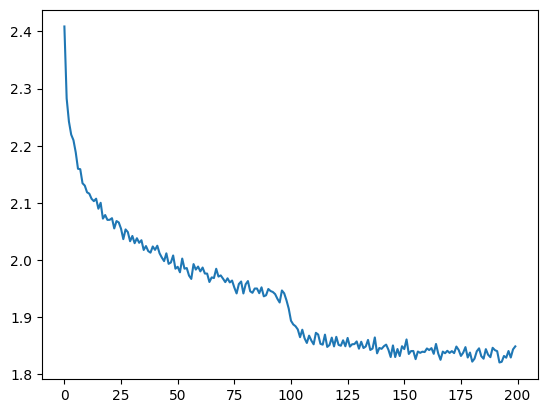

In [11]:
# plot the loss by averaging every 1000 epochs
plt.plot(torch.tensor(losses).view(-1, 1000).mean(dim=1))

In [12]:
# after training, set each layer to eval mode (for batch norm especially)
for layer in model.layers:
    layer.training = False

# function to eval loss on any split
def split_loss(split):
    # get the split data
    X, Y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split]

    # predict
    logits = model(X)

    loss = F.cross_entropy(logits, Y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8024470806121826
val 1.9944995641708374
